In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [114]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [3]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/2018/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [4]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [5]:
for types in df.type.unique():
    print(types)    

Checkout


In [5]:
df=df[df['type']=='Checkout']

In [126]:
print("terminals (registers):",df.term.unique())

terminals (registesrs): [3 2 8 6 1 7 9 5 4]


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [7]:
df=df[df['term']<10]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 15 to 3030
Data columns (total 10 columns):
date      63802 non-null object
gross+    63802 non-null float64
gross-    63802 non-null float64
items     63802 non-null object
net       63802 non-null float64
oper      63802 non-null int64
term      63802 non-null int64
time      63802 non-null object
trans     63802 non-null int64
type      63802 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 5.4+ MB


In [8]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [9]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [10]:
pickle.dump(df,open('./pickles/df2018.p','wb'))

In [2]:
df = pickle.load(open('./pickles/df2018.p','rb'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831284 entries, 5 to 2824
Data columns (total 12 columns):
date           831284 non-null datetime64[ns]
gross+         831284 non-null float64
gross-         831284 non-null float64
items          831284 non-null object
net            831284 non-null float64
oper           831284 non-null int64
term           831284 non-null int64
time           831284 non-null object
trans          831284 non-null int64
type           831284 non-null object
day_of_week    831284 non-null object
month          831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 82.4+ MB


In [13]:
#quarter1 = df[(df['month']>=1) & (df['month']<=3)]

## Import just one day into a dataframe 

In [14]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831284 entries, 5 to 2824
Data columns (total 12 columns):
date           831284 non-null datetime64[ns]
gross+         831284 non-null float64
gross-         831284 non-null float64
items          831284 non-null object
net            831284 non-null float64
oper           831284 non-null int64
term           831284 non-null int64
time           831284 non-null object
trans          831284 non-null int64
type           831284 non-null object
day_of_week    831284 non-null object
month          831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 82.4+ MB


In [70]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=150)

<class 'list'>


In [71]:
Counter(item_dict).most_common(50)

[('BAG CREDIT', 492884),
 ('SF Bag Charge', 144796),
 ('SMALL COOLER CRV', 136438),
 ('BANANAS', 95544),
 ('AVOCADOS HASS', 76003),
 ('ONIONS YELLOW', 61469),
 ('8 OZ BIO TUB t3', 50314),
 ('APPLES FUJI', 46601),
 ('GARLIC WHITE', 44169),
 ('CRV LRG SING NOTAX', 43423),
 ('CRV SMALL NO TAX', 40854),
 ('CRV SMALL SING T', 38122),
 ('LEMONS', 37909),
 ('LARGE COOLER CRV', 36818),
 ('PEPPERS RED BELL', 35455),
 ('16OZ BIO TUB t4', 33923),
 ('CELERY', 33737),
 ('KALE DINO', 32089),
 ('BOTTLE DEPOSIT', 31374),
 ('CARROTS LOOSE', 31286),
 ('SQUASH ZUCCHINI', 31191),
 ('ONIONS RED', 30458),
 ('CRV LRG SING T', 29929),
 ('CILANTRO', 29848),
 ('GINGER', 29740),
 ('CARROTS BUNCH', 27666),
 ('LIMES', 25607),
 ('CUCUMBERS', 24660),
 ('BAGEL', 24172),
 ('BROCCOLI LOOSE', 24144),
 ('ONIONS GREEN', 23789),
 ('1lb STRAWBERRY', 23581),
 ('PEPPER CHILI', 22860),
 ('SPINACH LOOSE', 22728),
 ('BEER SMALL CRV', 22597),
 ('MUSHROOM CRIMINI', 22147),
 ('PARSLEY ITALIAN', 21058),
 ('BEANS GREEN', 21016),
 ('L

In [72]:
len(items_set)

7555

In [73]:
df['item_count']=basket_counts

In [74]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [75]:
q1,q2,q3

(13.0, 18.0, 26.0)

In [118]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [76]:
df = df[df['item_count']>q2]

In [77]:
df['item_count'].max()

251

In [78]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [79]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [80]:
df.index

Int64Index([     1,      4,      6,      7,      9,     12,     13,     15,
                16,     17,
            ...
            393239, 393241, 393243, 393245, 393247, 393248, 393250, 393251,
            393252, 393255],
           dtype='int64', length=185214)

In [81]:
df=df.reset_index()

In [82]:
df.index

RangeIndex(start=0, stop=185214, step=1)

In [83]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items,item_count
count,185214.000000,185214.000000,185214.000000,185214.000000,185214.000000,185214.000000,185214.000000,185214.000000,185214.0,185214.000000
mean,197525.035073,155.646991,4.901981,150.745398,54.480887,5.081074,140.583363,6.541034,0.0,31.048182
std,113700.136494,296.916066,281.347688,93.517499,27.106113,2.128491,89.763352,3.489264,0.0,12.689842
min,1.000000,0.000000,0.000000,-481.450000,6.000000,1.000000,1.000000,1.000000,0.0,19.000000
25%,98822.250000,92.690000,0.000000,91.010000,27.000000,3.000000,64.000000,3.000000,0.0,22.000000
50%,198165.500000,130.320000,0.000000,128.190000,57.000000,5.000000,132.000000,7.000000,0.0,27.000000
75%,296066.750000,187.180000,1.240000,184.070000,79.000000,7.000000,207.000000,10.000000,0.0,36.000000
max,393255.000000,86643.090000,86502.310000,3727.590000,110.000000,9.000000,637.000000,12.000000,0.0,251.000000


In [84]:
df.pop('index')
print ()

In [85]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185214 entries, 0 to 185213
Data columns (total 14 columns):
date              185214 non-null datetime64[ns]
gross+            185214 non-null float64
gross-            185214 non-null float64
items             185214 non-null object
net               185214 non-null float64
oper              185214 non-null int64
term              185214 non-null int64
time              185214 non-null object
trans             185214 non-null int64
type              185214 non-null object
day_of_week       185214 non-null object
month             185214 non-null int64
total_of_items    185214 non-null int64
item_count        185214 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 19.8+ MB


In [86]:
df.iloc[:,0].index


RangeIndex(start=0, stop=185214, step=1)

In [87]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=185214, step=1)

In [88]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [89]:
#col_index_dict

In [90]:
matrix = np.zeros(df_items.shape)
matrix.shape

(185214, 7555)

In [91]:
df.shape[0]

185214

In [137]:
    matrix_dict = defaultdict(int)
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            #if item[1] not in stopwords and item[3] != 12:
            #if item[1] not in stopwords and item[3] not in (12,16):
            if item[1] not in stopwords and item[3] == 15:
                if item[2] > 0:
                    value = 1
                elif item[2] == 0:
                    value = 0
                else:
                    value = -1
                matrix_dict[i,col_index_dict[item[1]]] += value #+ matrix_dict[(i,item[1])]
                #matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + value
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [138]:
len(matrix_dict)

551514

In [139]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

0
5526
1


In [140]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [131]:
len(rows)

551514

In [132]:
import pickle

In [66]:
sparse_matrix[4]

<1x8945 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [70]:
pickle.dump(sparse_matrix,open('./pickles/sparse_matrix2018.p','wb'))

In [71]:
pickle.dump(items_set,open('./pickles/items_set2018.p','wb'))

In [43]:
file = open("./sparse_matrix201802orig.p",'rb')
sparse_matrix_orig = pickle.load(file)
file.close()

In [ ]:
for s in sparse_matrix[1:,9]:
    print (s)

In [63]:
for s in sparse_matrix_orig[0]:
    print (s)

  (0, 852)	1


In [48]:
diff = sparse_matrix-sparse_matrix_orig

In [49]:
diff.sum()

51149

In [40]:
file = open("./sparse_matrix201802.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [41]:
file = open("./items_set201802.p",'rb')
items_set = pickle.load(file)
file.close()

In [142]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [143]:
sum(np.sum(sparse_matrix,axis=1)==0)

matrix([[33767]])

In [102]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(sparse_matrix.shape[0]):
    if sparse_matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

801


In [144]:
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

0.004324727072467524 % of zero weight baskets


In [ ]:
#Set all negative values in the matrix to 0.
#matrix = pickle.load('matrix.p','rb')
#matrix = (matrix > 0).astype(int)

In [103]:
matrix.shape[0]

NameError: name 'matrix' is not defined

In [47]:
sparse_matrix[1111].sum()

6

In [75]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [76]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [78]:
scores =[]
for i in range(1,25,5):
    iter=i
    iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
    print(iteration,score)
    scores.append([iteration,score,model_iter])

NameError: name 'scoring' is not defined

In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [79]:
#scores

In [80]:
#just_scores

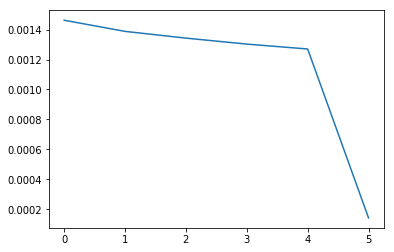

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [ ]:
rebuilt = np.dot(W,H)

In [ ]:
rebuilt.shape

In [ ]:
matrix.shape

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [150]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=7,max_iter=250)

In [151]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 43 W shape: (185214, 7) H shape: (7, 7551)


In [152]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d srength: %f '%(i,t))

topic 0 srength: 0.230000 
topic 1 srength: 0.190000 
topic 2 srength: 0.030000 
topic 3 srength: 0.060000 
topic 4 srength: 0.160000 
topic 5 srength: 0.180000 
topic 6 srength: 0.150000 


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_

In [107]:
H[:,6249]

array([0.00568646, 0.        , 0.00035769, 0.00134455, 0.        ,
       0.        , 0.00069092, 0.00292025, 0.00037241, 0.        ])

In [115]:
len(items_set)

13028

In [113]:
for topic in H:
    print (topic[:-10:-1])

[0.         0.00441505 0.00980141 0.012876   0.00077077 0.00070029
 0.00279214 0.00139771 0.00023004]
[0.         0.0003581  0.00854664 0.00034471 0.         0.
 0.00219412 0.0002887  0.        ]
[0.00303419 0.         0.         0.         0.         0.
 0.         0.         0.        ]
[1.10003786e-03 7.70094654e-05 0.00000000e+00 7.28138922e-04
 2.05204203e-04 0.00000000e+00 5.68327946e-04 0.00000000e+00
 0.00000000e+00]
[0.00634289 0.         0.00058664 0.00592629 0.         0.
 0.         0.         0.00058325]
[0.         0.         0.         0.01045207 0.00373818 0.
 0.         0.00050529 0.00150277]
[0.         0.         0.00644136 0.00168612 0.00385706 0.
 0.         0.         0.        ]
[0.00431008 0.         0.         0.00289049 0.         0.00380935
 0.0015475  0.00651437 0.00030573]
[0.00108092 0.00126485 0.00048298 0.00138168 0.         0.00388154
 0.         0.0004808  0.00189265]
[0.00409015 0.00117578 0.00151741 0.         0.         0.
 0.00086623 0.         0. 

In [70]:
file = open("./pickles/items_set.p",'rb')
items_set = pickle.load(file)
file.close()

In [153]:
feature_names=list(items_set).copy()
n_top_words=50
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[1961 7181 6024 5259 4374 7228 7403 3061 6433 5296 4391 3692 1090  335
  560 5921  371  249 6386 3378 1253 5277 4399 7072 5033 7155 5260 1954
  895 3359 3501 5111 5872 3095 2847 2530 5736 5491 7420 2378 3545 3252
 4190 6497 1131 3347  376 1122 3179 1292]
['LACROIX GRPFRT12pk', 'LACROIX TNGRN12pk', 'LACROIX LIME 12pk', 'LACROIX PLAIN 12pk', 'LACROIX PSNFRT 8PK', 'LA CROIX APRICO8PK', 'LACROIX COCONUT8PK', 'LACROIX LEMON 8PK', 'LACROIX-CHRRY LIME', 'LACROIX PEACH PEAR', 'LACROIX MANGO 8PK', 'ANGIE-SSALT POPCRN', 'LACROIX-MurePEPINO', 'LACROIX CRNRSP 8PK', 'LUND-BRN RICE CAKE', 'KEY LIME 12 PACK', 'LACROIX-PIN/STRAW', 'BD-UNS ALMD BREEZE', 'BD-SSALT NUT THINS', 'LACROIX-NICOLA', 'LACROIX-MLN POMELO', 'SIMPLY NKD PITA CH', 'NEWMAN-THIN PRETZL', 'GIMME-SSALTsnk6pk', 'NUMI GUNPOWDER', 'LACROIX-KiwiSANDIA', 'GEROLSTEINER', 'INKA PLANTAINS 4oz', 'OI OCHA GRN TEA', 'LACROIX GFRUIT 8PK', 'CASASAN THICK CHIP', 'CASASAN THIN CHIPS', 'JUSTIN-MINI PB CUP', 'RX BAR-BLUEBERRY', 'LACROIX-APPLE CRAN', '

0.23 Topic #0:
['LACROIX GRPFRT12pk', 'LACROIX TNGRN12pk', 'LACROIX LIME 12pk', 'LACROIX PLAIN 12pk', 'LACROIX PSNFRT 8PK', 'LA CROIX APRICO8PK', 'LACROIX COCONUT8PK', 'LACROIX LEMON 8PK', 'LACROIX-CHRRY LIME', 'LACROIX PEACH PEAR', 'LACROIX MANGO 8PK', 'ANGIE-SSALT POPCRN', 'LACROIX-MurePEPINO', 'LACROIX CRNRSP 8PK', 'LUND-BRN RICE CAKE', 'KEY LIME 12 PACK', 'LACROIX-PIN/STRAW', 'BD-UNS ALMD BREEZE', 'BD-SSALT NUT THINS', 'LACROIX-NICOLA', 'LACROIX-MLN POMELO', 'SIMPLY NKD PITA CH', 'NEWMAN-THIN PRETZL', 'GIMME-SSALTsnk6pk', 'NUMI GUNPOWDER', 'LACROIX-KiwiSANDIA', 'GEROLSTEINER', 'INKA PLANTAINS 4oz', 'OI OCHA GRN TEA', 'LACROIX GFRUIT 8PK', 'CASASAN THICK CHIP', 'CASASAN THIN CHIPS', 'JUSTIN-MINI PB CUP', 'RX BAR-BLUEBERRY', 'LACROIX-APPLE CRAN', 'LACROIX LIME8PK', 'ANNIE BRRYBNNY FRT', 'HERITAGE FLAKE bag', 'SPIND-RASP SELTZER', 'LUND TAMARI RICECA', 'SF-ORIG PRTZS CRSP', 'MARYS - EVERYTHING', 'LUND-N/S RICE CAKE', 'RX BAR-PEANUT BTTR', 'BARK -CHOC PRETZEL', 'LACROIX-PURE 8PK', 'CHO

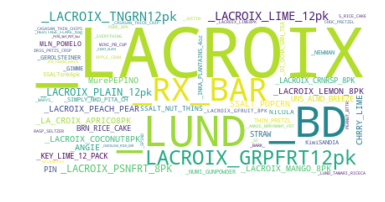

<img src="./img/2018/1554323888.topic0.png">
0.19 Topic #1:
['EDEN GARBANZOS', 'EDEN BLACKBEANS 15', 'EDEN CANNELLINI BE', 'EDEN KIDNEY BEANS', 'TK ORG COCONUT MLK', 'EDEN PINTO BN 15oz', 'NF-COCO MILK- CAN', 'PACIFIC LS VEG BRO', 'MUIR-TOMATO PASTE', 'MUIR DICED TOMATOS', 'PAC-VEG BROTH 32oz', 'FARMER PUMPKIN-CAN', 'BIONATURAE TOM PAS', 'CAL OLIVE OIL 25oz', 'THAI COCONUT MILK', 'LUND-BRN RICE CAKE', 'MUIR DICED TOM N/S', 'DELREAL DATES', 'EDEN BUTTER BEANS', 'NF-COCO MILK- SIMP', 'MUIR-DICED TOMATO', 'EDEN BLACK EYED PE', 'GREAT NORTHERN BEA', 'GIMME-SSALTsnk6pk', 'NV MED PITTD OLIVE', 'IMAGINE LS VEG BRO', 'BARIANI OIL 1LITER', 'BD-UNS ALMD BREEZE', 'EDEN NAVYBEANS 15O', 'EDEN GARBANZO 29oz', 'DICED TOMS NO SALT', 'PAC OAT ORIG 32oz', 'SC APPLE SAUCE CUP', 'CASASAN THICK CHIP', 'WESTBRAE-BLK BEANS', 'NF COCONUT CREAM', 'PAC ALM UNSORIG 32', 'BRAGG-APPLciderVIN', 'HERITAGE FLAKE bag', 'CADIA TOM PASTE', 'ADUKI BEANS', 'DANDELION CHOC BAR', 'MUIR FIRE RSTD TOM', 'TK RED CURRY PASTE', 

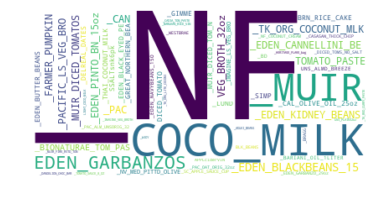

<img src="./img/2018/1554323888.topic1.png">
0.03 Topic #2:
['NAPA-OLIVE OIL25oz', 'TK ORG COCONUT MLK', 'FARMER PUMPKIN-CAN', 'KARLIN BAKING SODA', 'PAC ALM UNSORIG 32', 'BIONATURAE TOM PAS', 'MUIR DICED TOMATOS', 'LUND-BRN RICE CAKE', 'NF-COCO MILK- CAN', 'NAPA V RED WINE VI', 'CORN FLAKES ecopac', 'BTB VEGETABLE BASE', 'RIVER-CRMY ALMDbtr', 'FERIDIES PEANUTS', 'UNSWEET COCONUT MI', 'PAC-VEG BROTH 32oz', 'DrB COCO OIL 30oz', 'GEROLSTEINER', 'IL CASOLARE OLVE O', 'BRAGG-APPLciderVIN', 'NAPA GOLDEN BALSAM', 'MILKADAMIA-UNSWEET', 'HERITAGE FLAKE bag', 'KOSHER SALT 48oz', 'COOMB MAPLE A 32oz', 'BIO STRAINED TOMAT', 'NAPA TSTD SES OIL', 'MARUKAN RICE VIN', 'PACIFIC LS VEG BRO', 'ChFOOD AVOCADO OIL', 'MUIR-WHL PEEL TOMS', 'BD-UNS ALMD BREEZE', 'BIONAT ORG PENNE', 'JOVIAL CRUSHED TOM', 'BALSAMIC VINEGAR', 'FD-CANNELLINI BEAN', 'THAI COCONUT MILK', 'BNFIELD-NACHO CHIP', 'MONARI ORG BALSAMI', 'ORGANIC PENNE', 'GIMME-SSALTsnk6pk', 'IMAGINE VEG BROTH', 'ORGANIC FUSILLI', 'BARIANI OIL 1LITER', '

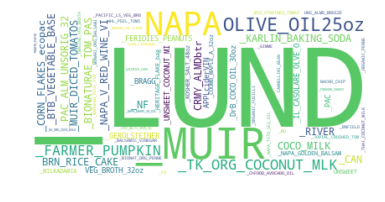

<img src="./img/2018/1554323889.topic2.png">
0.06 Topic #3:
['HAVE A CHIP', 'GIMME-SSALTsnk6pk', 'PLOTE RSTTOM SALSA', 'CASASAN THIN CHIPS', 'LUND TAMARI RICECA', 'BROWN RICE THINS', 'MINERAL WATER', 'CASASAN THICK CHIP', 'PELLEGRINO -750 ML', 'LACROIX LIME 12pk', 'LACROIX PSNFRT 8PK', 'PAC ALM UNSORIG 32', 'PRIMAVERA TOR CHIP', 'NEWMAN SPELT PRETZ', 'ELDERFLOWER TONIC', 'TK ORG COCONUT MLK', 'SANJ BLK SES CRKR', 'INKA PLANTAINS 4oz', 'BD-SSALT NUT THINS', 'GUITTARDCHOCO CHIP', 'SIGHT GLASS', 'F-TREE TONIC 16oz', 'SPRAY AVOCADO OIL', 'ROASTED TOM SALSA', 'WESTBRAE-BLK BEANS', 'HINT BLKBERRY WATE', 'LUND-BRN RICE CAKE', 'GREEN NOODLE SOY', 'KOYO TOFU MISO RAM', 'LACROIX TNGRN12pk', 'NEWMAN-THIN PRETZL', 'SIMPLY NKD PITA CH', 'Qualita Oro Espres', 'CAL OLIVE OIL 25oz', 'WSOY-UNS PLAIN32oz', 'HINT WATERMELON', 'BTN-HRVST WHT CRKR', 'PAC-VEG BROTH 32oz', 'FD-CANNELLINI BEAN', 'THAI COCONUT MILK', 'GREEN CHILI REFRIE', 'GIMME-TERIYAKi 6pk', 'SESAME RICE THINS', 'INKA RSTD CORN 4oz', 'JUSTIN

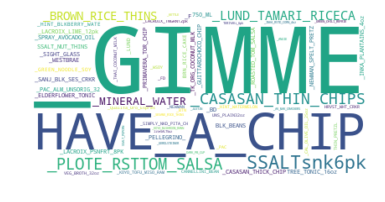

<img src="./img/2018/1554323890.topic3.png">
0.16 Topic #4:
['Sabor Orig', 'LACROIX LIME 12pk', 'ANGIE-SSALT POPCRN', 'GIMME-SSALTsnk6pk', 'PLOTE RSTTOM SALSA', 'CAL OLIVE OIL 25oz', 'PRIMAVERA TOR CHIP', 'SIGHT GLASS', 'MUIR-TOMATO PASTE', 'BTN-HRVST WHT CRKR', 'FARMER PUMPKIN-CAN', 'ORGANIC PENNE', 'MONTEBL TORCHIETTE', 'SIMPLY NKD PITA CH', 'ORGANIC FUSILLI', 'BD-SSALT NUT THINS', 'PELLEGRINO -750 ML', 'MILKADAMIA-UNSWEET', 'NEWMAN-THIN PRETZL', 'TK ORG COCONUT MLK', 'ROASTED TOM SALSA', 'BRAGG-APPLciderVIN', 'LUND-BRN RICE CAKE', 'HOMEMADE-BLUE CHIP', 'CASC FARM PURELY O', 'WESTBRAE-BLK BEANS', 'LACROIX PLAIN 12pk', 'GIMME-SESAME SNACK', 'MARYS - EVERYTHING', 'CHIPOTLE SALSA', 'HERITAGE FLAKE bag', 'BARIANI OIL 1LITER', 'FD-CANNELLINI BEAN', 'CRUSHED', 'SIMPLE-SSALT CRCKR', 'LJULY-MINI PBcrckr', 'MUIR-DICED TOMATO', 'BTN-CRSPY WHT CRKR', 'INKA PLANTAINS 4oz', 'PAC ALM UNSORIG 32', 'MARYclassicCRACKER', 'MINERAL WATER', 'LUND-N/S RICE CAKE', 'NV MED PITTD OLIVE', 'IMAGINE VEG BROTH'

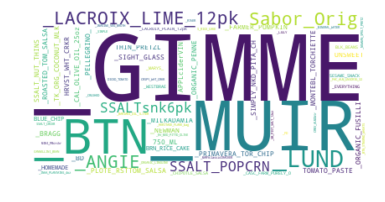

<img src="./img/2018/1554323890.topic4.png">
0.18 Topic #5:
['BRAGGS CIDER VINEG', 'KARLIN BAKING SODA', 'BRAGG-APPLciderVIN', 'TK ORG COCONUT MLK', 'MUIR-TOMATO PASTE', 'MILKADAMIA-UNSWEET', 'CAL OLIVE OIL 25oz', 'ANGIE-SSALT POPCRN', 'PAC OAT ORIG 32oz', 'LUND-BRN RICE CAKE', 'PAC ALM UNSORIG 32', 'BARIANI OIL 1LITER', 'BIONATURAE TOM PAS', 'PELLEGRINO -750 ML', 'MARUKAN RICE VIN', 'PAC-VEG BROTH 32oz', 'NF-COCO MILK- SIMP', 'NF-COCO MILK- CAN', 'INKA PLANTAINS 4oz', 'GEROLSTEINER', 'BAKING POWDER 4 OZ', 'TEMPT-unswtORIGINL', 'DELREAL DATES', 'Heavy Coconut Crea', 'THAI COCONUT MILK', 'TK RED CURRY PASTE', 'NF COCONUT CREAM', 'UNSWEET COCONUT MI', 'S CRUZ LEMON JUICE', 'DrB COCO OIL 14oz', 'DrB COCO OIL 30oz', 'BD-UNS ALMD BREEZE', 'CADIA TOM PASTE', 'DISTILLED VINEGAR', 'FARMER PUMPKIN-CAN', 'SPECTRUM ORG VINEG', 'GOE BLUE CORN 8oz', 'ChFOOD AVOCADO OIL', 'GRADE A MAPLE SYRU', 'BRAGG LQD AMNO16oz', 'BTB VEGETABLE BASE', 'LUND-N/S RICE CAKE', 'CHOLULA HSAUCE 5oz', 'FD-CANNELLINI BEAN

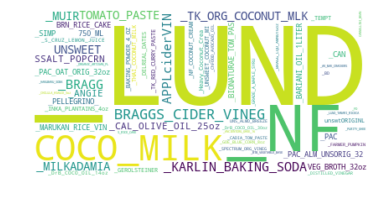

<img src="./img/2018/1554323891.topic5.png">
0.15 Topic #6:
['MtV SPRKLING 1 LTR', 'NF-COCO MILK- CAN', 'BRAGG-APPLciderVIN', 'GEROLSTEINER', 'PELLEGRINO -750 ML', 'CAL OLIVE OIL 25oz', 'SPARKLING LIME', 'NF-COCO MILK- SIMP', 'MINERAL WATER', 'LAIKI-blkRICE CRKR', 'FARMER PUMPKIN-CAN', 'SPARKLING BLACKBER', 'INKA PLANTAINS 4oz', 'GIMME-SSALTsnk6pk', 'PAC ALM UNSORIG 32', 'KARLIN BAKING SODA', 'MILKADAMIA-UNSWEET', 'PAC-VEG BROTH 32oz', 'BIONATURAE TOM PAS', 'LAIKI-redRICE CRKR', 'PAC UNSWT HEMPMILK', 'LUND-N/S RICE CAKE', 'ANGIE-SSALT POPCRN', 'BARIANI OIL 1LITER', 'PRIMAVERA TOR CHIP', 'RIVER-CRMY ALMDbtr', 'LUND-BRN RICE CAKE', 'DrB COCO OIL 30oz', 'GUAYAKI CLSSC GOLD', 'NF COCONUT CREAM', 'NAIRN-OATMEAL CKY', 'SESAME RICE THINS', 'SF-EVERYTHING PRTZ', 'ORGANIC WATER CRAC', 'MARCONA ALMONDS', 'MARYclassicCRACKER', 'FD-CANNELLINI BEAN', 'MARYS - EVERYTHING', 'MARYS-HERB CRACKER', 'TONY-MILK CHOC BAR', 'MARYS-SEAWD SESAME', 'Heavy Coconut Crea', 'LUND TAMARI RICECA', 'NOCCIOLATA', 'CAS

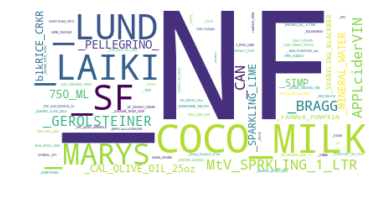

<img src="./img/2018/1554323891.topic6.png">


In [154]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print(topic_strength[topic_idx],"Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        img_time=str(time.time()).split('.')[0]
        wordcloud.to_file('./img/2018/%s.topic%d.png'%(img_time,topic_idx))
        print('<img src="./img/2018/%s.topic%d.png">'%(img_time,topic_idx))
    return topic_dict
topics = print_top_items(model,list(items_set),n_top_words)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [65]:
topics3=topics.copy()

In [66]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
print (topic_strength)            
print(topic_compare)


[0.93 0.01 0.01 0.02 0.03]
[[50.  8.  8. 23. 13.]
 [ 8. 50. 22.  5. 19.]
 [ 8. 22. 50.  7. 16.]
 [23.  5.  7. 50. 11.]
 [13. 19. 16. 11. 50.]]


In [67]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [45]:
len(topics[0])

50

In [ ]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

In [47]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [225]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [231]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [233]:
ingredients.shape

(5, 55)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [244]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

array([[ 63.,  99.,  42.,  64., 112.,  14.,  21., 124.,  32.,  35.,  88.,
         68., 121., 130., 113., 120.,  38.,  95., 134.,  10.,  23.,  16.,
         27.,  41.,  96., 118.,  58., 101., 105.,  85.,  97.,  47.,  86.,
         29.,  20.,  91.,  15.,  55., 102.,  28.,  98.,   1., 119., 122.,
        132.,  11., 128.,  65.,  17.,  72.,  54.,   0.,  81., 125.,  25.],
       [100.,  32.,  64.,  19.,  88.,   1., 120.,  86.,   3.,   9.,  39.,
        105., 134.,  41.,  78.,  69.,  93., 131., 124.,  48.,  34.,  97.,
         67.,  57., 112.,  62.,  74.,   7.,  16.,  44., 115.,  91.,  65.,
         11., 123.,  14.,  68.,  53., 107.,  51.,  31.,   6.,  98., 102.,
         24., 121.,  61.,  49.,  55.,  12.,  82., 101., 133.,  60.,  75.],
       [ 37., 115.,  96.,  97.,  21.,   1.,  58.,  77.,  35.,   3., 105.,
        118.,  71., 130.,  85., 131., 104.,  87.,  19.,  15.,  43.,  38.,
        101.,   0.,  41.,   2.,  13., 127.,  62., 121.,  18.,  89.,  32.,
        102.,  50., 126.,  65.,  30.

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [68]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [69]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'NG Arthred 240gram', 45.45, 1]
item: ['', 'Now Taurine 1000 m', 20.78, 1]
item: ['', 'SG Vit D-3 5000 24', 29.12, 1]
item: ['', 'PN Vit-C 500m180vg', 20.63, 1]
item: ['', 'Now Leangels 120ct', 55.98, 1]
item: ['', 'CL CoEnzymeBplex12', 21.69, 1]
item: ['', 'CL CoEnzymeBplex12', 21.69, 1]
item: ['', 'NO Tyrosine 120cp', 12.78, 1]
item: ['', 'JR Gamma E-300 120', 30.36, 1]
item: ['', 'JR Gamma E-300 120', 30.36, 1]
item: ['', 'JR Red Glut 500mg', 32.76, 1]
item: ['', 'JR Hyaluronic 120c', 28.76, 1]
item: ['', 'EZ Resveratrol 60g', 20.39, 1]
item: ['', 'TW DMAE 100cap', 8.39, 1]
item: ['', 'NO Silymarin 120vc', 13.5, 1]
item: ['', 'NO L-Carnosine 100', 43.18, 1]
item: ['', 'NO Relora 120vcap', 30.38, 1]
item: ['', 'NO Arginine500mg25', 19.19, 1]
item: ['', 'GI Turmeric 120cap', 31.99, 1]
item: ['', 'GI Turmeric 120cap', 31.99, 1]
item: ['', 'GoL Zinc', 9.99, 1]
item: ['', 'GoL Zinc', 9.99, 1]
item: ['', 'NA Boswellia 90v

item: ['', 'MY Zhong Gan Ling', 12.45, 1]
item: ['', 'SIETE - LIME CHIPS', 5.19, 15]
item: ['', 'EC EldrBry 2oz', 20.4, 1]
item: ['', 'Coconut Towlettes', 6.99, 4]
item: ['', 'GARLIC WHITE', 1.28, 12]
item: ['', 'LEMONS', 1.1, 12]
item: ['', 'BO Oscillococcinum', 13.55, 1]
item: ['', 'BANANAS', 3.89, 12]
item: ['', 'ONIONS RED', 0.91, 12]
item: ['', 'ZD HerbaLoz Menthl', 2.56, 1]
item: ['', 'ZD HerbaLoz Menthl', 2.56, 1]
item: ['', 'ZD ElderberryLozen', 2.62, 1]
item: ['', 'ZD Echinacea ZincL', 2.48, 1]
item: ['', 'JENNIES -GOJI MOJI', 1.79, 15]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', 'GRAPES RED', 6.61, 12]
item: ['', 'SIERRA ORG CC TUB', 4.49, 14]
item: ['', '16oz COTTAGE CHEES', 3.85, 13]
item: ['', 'BLACKBERRY PACK', 5.99, 12]
item: ['', 'ZD Elderberry 15 L', 2.62, 1]
item: ['', 'ZD Echinacea ZincL', 2.48, 1]
item: ['', 'DB Vit D3 5000iu 1', 9.6, 1]
item: ['', 'NF C500mg Berry 18', 18.0, 1]
item: ['', 'RASPBERRIES', 6

++++++++++++++++++Topic #4, basket #1+++++++++++++++++++
item: ['', 'CAB BATH TISSUE 12', 13.49, 7]
item: ['', 'SEMIFREDDIS LOAF', 3.59, 17]
item: ['', 'SPINACH LOOSE', 4.0, 12]
item: ['', 'SHIITAKES BABY', 4.03, 12]
item: ['', 'PAELLA RICE', 4.59, 15]
item: ['', 'JR MilkThistle 100', 11.25, 1]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'SATSUMA MANDARIN', 4.63, 12]
item: ['', 'RL Counter Attack', 12.75, 1]
item: ['', 'SV Sov Silver10p 2', 12.75, 1]
item: ['', 'BEETS RED LOOSE', 3.84, 12]
item: ['', 'KL Charcoal 50cap', 6.39, 1]
item: ['', 'HN SOL Ad Multi', 20.4, 1]
item: ['', 'WO Chlorophyll 50c', 5.53, 1]
item: ['', 'HHealth Vitamin EO', 5.95, 4]
item: ['', 'MtV SPRKLING 1 LTR', 1.99, 15]
item: ['', 'CRV LRG SING T', 0.1, 15]
item: ['', 'MtV SPRKLING 1 LTR', 1.99, 15]
item: ['', 'CRV LRG SING T', 0.1, 15]
item: ['', 'MtV SPRKLING 1 LTR', 1.99, 15]
item: ['', 'CRV LRG SING T', 0.1, 15]
item: ['', 'MtV SPRKLING 1 LTR', 1.99, 15]
item: ['', 'CRV LRG SING T', 0.1, 15]
item: [''

In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

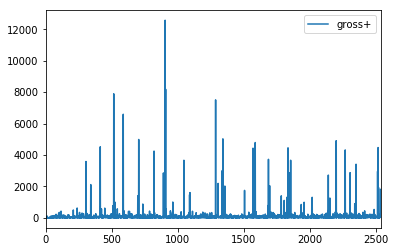

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [ ]:
df[df['BANANAS']!=0]

In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [54]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [1]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

NameError: name 'get_dataframe' is not defined

In [ ]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

In [ ]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185214 entries, 0 to 185213
Data columns (total 14 columns):
date              185214 non-null datetime64[ns]
gross+            185214 non-null float64
gross-            185214 non-null float64
items             185214 non-null object
net               185214 non-null float64
oper              185214 non-null int64
term              185214 non-null int64
time              185214 non-null object
trans             185214 non-null int64
type              185214 non-null object
day_of_week       185214 non-null object
month             185214 non-null int64
total_of_items    185214 non-null int64
item_count        185214 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 19.8+ MB


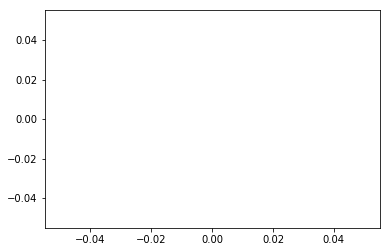

In [123]:
plt.scatter(dfq1['item_count'],dfq1['term'])